In [ ]:
!pip -q install vit_pytorch linformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 KB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 421.6 kB/s eta 0:00:00


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/train_vit.zip

**Prueba GAIT **

In [ ]:
!unzip /content/gdrive/MyDrive/GEI_AGE.zip

In [ ]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT

In [ ]:
# Training settings
batch_size = 64
epochs = 60
lr = 3e-5
gamma = 0.6
seed = 42
device = 'cuda'

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
import csv
import os
import shutil

csv_file = "/content/gdrive/MyDrive/Age_gender_info.csv"
train_dir = "train_vit"
test_dir = "test_vit"
train_split_ratio = 0.8

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Read CSV file and split into train and test sets
with open(csv_file, "r") as f:
    reader = csv.reader(f)
    next(reader)  # skip header row
    for row in reader:
        file_name, label = row[0], row[2] # 1 Age 2 Gender
        src_path = os.path.join(".", "/content/GEI/"+file_name+".png")
        if not os.path.isfile(src_path):
            print(f"File not found: {file_name}")
            continue
        dst_dir = train_dir if hash("/content/GEI/"+file_name+".png") % 100 < 100 * train_split_ratio else test_dir
        dst_path = os.path.join(dst_dir, label,file_name+".png")
        os.makedirs(os.path.join(dst_dir, label), exist_ok=True)
        shutil.copy(src_path, dst_path)

In [ ]:
train_dir = "/content/train_vit"
test_dir ="/content/test_vit"

train_list_1 = []
test_list_1 = []

# iterate over subdirectories in train_dir and add files to train_list
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            if file.endswith(".png"):
                train_list_1.append(os.path.join(subdir_path, file))

# iterate over subdirectories in test_dir and add files to test_list
for subdir in os.listdir(test_dir):
    subdir_path = os.path.join(test_dir, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            if file.endswith(".png"):
                test_list_1.append(os.path.join(subdir_path, file))

# randomly shuffle train_list and test_list
random.shuffle(train_list_1)
random.shuffle(test_list_1)

In [ ]:
print(f"Train Data: {len(train_list_1)}")
print(f"Test Data: {len(test_list_1)}")

Train Data: 51041
Test Data: 12805


In [ ]:
labels_1 = [path.split('/content/train_vit/')[-1].split('/')[0] for path in train_list_1]

In [ ]:
#Gender
train_list_1, valid_list_1 = train_test_split(train_list_1,
                                          test_size=0.2,
                                          stratify=labels_1,
                                          random_state=seed)

In [ ]:

train_list_1, valid_list_1 = train_test_split(train_list_1,
                                          test_size=0.2,
                                          stratify=labels_1,
                                          random_state=seed)

In [ ]:
#AGE
import numpy as np
from sklearn.model_selection import train_test_split

# Get indices of samples for each label
label_indices = [np.where(np.array(labels_1) == l)[0] for l in set(labels_1)]

# Remove labels with only one sample
label_indices = [indices for indices in label_indices if len(indices) > 1]

# Flatten the list of indices
indices = np.concatenate(label_indices)

# Split data using the remaining indices
train_indices, valid_indices = train_test_split(indices,
                                                test_size=0.2,
                                                stratify=np.array(labels_1)[indices],
                                                random_state=seed)

# Split data based on the new indices
train_list_1 = [train_list_1[i] for i in train_indices]
#valid_list_1 = [train_list_1[i] for i in valid_indices]

In [ ]:
valid_indices = [i for i in valid_indices if i >= 0 and i < len(train_list_1)]
valid_list_1 = [train_list_1[i] for i in valid_indices]


In [ ]:
print(f"Train Data: {len(train_list_1)}")
print(f"Validation Data: {len(valid_list_1)}")
print(f"Test Data: {len(test_list_1)}")

Train Data: 40832
Validation Data: 10209
Test Data: 12805


In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [ ]:
class GEIDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        #print(img_path.shape)
        img_transformed = self.transform(img)

        label = img_path.split('/content/train_vit/')[-1].split('/')[0]
        if (label =='M'):
          label=0
        else:
          label=1

        return img_transformed,label

In [ ]:
class AgeGEIDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        #print(img_path.shape)
        img_transformed = self.transform(img)

        #label = int(img_path.split('/content/train_vit_2/')[-1].split('/')[0])
        label_str = img_path.split('/content/train_vit_2/')[-1].split('/')[0]
        label = int(label_str) if label_str.isdigit() else -1
        #print(label)
        return img_transformed,label

In [ ]:
from collections import Counter

number_class=len(Counter(labels_1))


In [ ]:
#AGE
train_data_1 = AgeGEIDataset(train_list_1, transform=train_transforms)
valid_data_1 = AgeGEIDataset(test_list_1, transform=test_transforms)

In [ ]:
train_loader_1 = DataLoader(dataset = train_data_1, batch_size=batch_size, shuffle=True )
valid_loader_1 = DataLoader(dataset = valid_data_1, batch_size=batch_size, shuffle=True)

In [ ]:
#Gender
train_data_1 = GEIDataset(train_list_1, transform=train_transforms)
valid_data_1 = GEIDataset(test_list_1, transform=test_transforms)
test_data_1 = GEIDataset(test_list_1, transform=test_transforms)

In [ ]:
train_loader_1 = DataLoader(dataset = train_data_1, batch_size=batch_size, shuffle=True )
valid_loader_1 = DataLoader(dataset = valid_data_1, batch_size=batch_size, shuffle=True)
test_loader_1 = DataLoader(dataset = test_data_1, batch_size=batch_size, shuffle=True)

In [ ]:
efficient_transformer1 = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [ ]:
model1 = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer1,
    channels=1,
).to(device)

In [ ]:
# loss function
criterion1 = nn.CrossEntropyLoss()
# optimizer
optimizer1 = optim.Adam(model1.parameters(), lr=lr)
# scheduler
scheduler1 = StepLR(optimizer1, step_size=1, gamma=gamma)

In [ ]:
epoch_loss = 0
epoch_accuracy = 0

In [ ]:
for epoch in range(epochs):
    epoch_loss1 = 0
    epoch_accuracy1 = 0

    for data1, label1 in tqdm(train_loader_1):
        data1 = data1.to(device)
        label1 = label1.to(device)

        output1 = model1(data1)
        loss1 = criterion1(output1, label1)

        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        acc1 = (output1.argmax(dim=1) == label1).float().mean()
        epoch_accuracy1 += acc1 / len(train_loader_1)
        epoch_loss1 += loss1 / len(train_loader_1)

    with torch.no_grad():
        epoch_val_accuracy1 = 0
        epoch_val_loss1 = 0
        for data1, label1 in valid_loader_1:
            data1 = data1.to(device)
            label1 = label1.to(device)

            val_output1 = model1(data1)
            val_loss1 = criterion1(val_output1, label1)

            acc1 = (val_output1.argmax(dim=1) == label1).float().mean()
            epoch_val_accuracy1 += acc1 / len(valid_loader_1)
            epoch_val_loss1 += val_loss1 / len(valid_loader_1)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss1:.4f} - acc: {epoch_accuracy1:.4f} - val_loss : {epoch_val_loss1:.4f} - val_acc: {epoch_val_accuracy1:.4f}\n"
    )

  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6897 - acc: 0.5344 - val_loss : 0.7229 - val_acc: 0.3879



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6596 - acc: 0.5972 - val_loss : 1.1338 - val_acc: 0.1897



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6132 - acc: 0.6521 - val_loss : 0.7070 - val_acc: 0.4559



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.5804 - acc: 0.6811 - val_loss : 0.4014 - val_acc: 0.8178



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.5548 - acc: 0.6982 - val_loss : 0.3226 - val_acc: 0.8664



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.5284 - acc: 0.7187 - val_loss : 0.5665 - val_acc: 0.6478



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.5158 - acc: 0.7283 - val_loss : 0.7422 - val_acc: 0.5544



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.5098 - acc: 0.7330 - val_loss : 0.7208 - val_acc: 0.5546



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.4996 - acc: 0.7432 - val_loss : 0.7081 - val_acc: 0.5627



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.4888 - acc: 0.7462 - val_loss : 0.7231 - val_acc: 0.6022



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.4852 - acc: 0.7471 - val_loss : 0.5024 - val_acc: 0.7169



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.4772 - acc: 0.7518 - val_loss : 0.3513 - val_acc: 0.8333



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.4692 - acc: 0.7588 - val_loss : 0.5631 - val_acc: 0.6848



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.4695 - acc: 0.7561 - val_loss : 0.6411 - val_acc: 0.6175



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.4602 - acc: 0.7687 - val_loss : 0.5075 - val_acc: 0.7233



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.4536 - acc: 0.7693 - val_loss : 0.5171 - val_acc: 0.7148



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.4500 - acc: 0.7734 - val_loss : 0.9041 - val_acc: 0.5021



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.4455 - acc: 0.7732 - val_loss : 1.0406 - val_acc: 0.4481



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.4424 - acc: 0.7763 - val_loss : 0.9601 - val_acc: 0.5129



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.4365 - acc: 0.7800 - val_loss : 0.7044 - val_acc: 0.6133



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.4335 - acc: 0.7835 - val_loss : 0.5593 - val_acc: 0.6861



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.4294 - acc: 0.7860 - val_loss : 0.6001 - val_acc: 0.6859



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.4283 - acc: 0.7883 - val_loss : 0.3129 - val_acc: 0.8538



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.4221 - acc: 0.7882 - val_loss : 1.1156 - val_acc: 0.4506



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.4220 - acc: 0.7908 - val_loss : 0.5353 - val_acc: 0.7259



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.4210 - acc: 0.7883 - val_loss : 0.5051 - val_acc: 0.7339



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.4161 - acc: 0.7918 - val_loss : 0.7005 - val_acc: 0.6299



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.4156 - acc: 0.7912 - val_loss : 0.7051 - val_acc: 0.6261



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.4072 - acc: 0.7981 - val_loss : 0.6020 - val_acc: 0.6798



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.4076 - acc: 0.8000 - val_loss : 0.4082 - val_acc: 0.7937



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.4086 - acc: 0.7973 - val_loss : 0.5316 - val_acc: 0.7103



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.4040 - acc: 0.7994 - val_loss : 0.3727 - val_acc: 0.8213



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.4018 - acc: 0.7998 - val_loss : 0.3726 - val_acc: 0.8157



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.3998 - acc: 0.8018 - val_loss : 0.3689 - val_acc: 0.8153



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.3972 - acc: 0.8051 - val_loss : 0.5320 - val_acc: 0.7330



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.3959 - acc: 0.8065 - val_loss : 0.5634 - val_acc: 0.7062



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.3934 - acc: 0.8065 - val_loss : 0.4018 - val_acc: 0.7999



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.3841 - acc: 0.8134 - val_loss : 0.3561 - val_acc: 0.8294



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.3850 - acc: 0.8129 - val_loss : 1.0418 - val_acc: 0.5574



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.3873 - acc: 0.8093 - val_loss : 0.5960 - val_acc: 0.6928



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.3852 - acc: 0.8109 - val_loss : 0.5498 - val_acc: 0.7211



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.3850 - acc: 0.8104 - val_loss : 0.5153 - val_acc: 0.7377



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.3823 - acc: 0.8135 - val_loss : 0.4269 - val_acc: 0.7874



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.3800 - acc: 0.8147 - val_loss : 0.4566 - val_acc: 0.7709



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.3771 - acc: 0.8155 - val_loss : 0.3167 - val_acc: 0.8479



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.3751 - acc: 0.8174 - val_loss : 0.4712 - val_acc: 0.7831



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.3721 - acc: 0.8190 - val_loss : 0.8590 - val_acc: 0.5797



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.3787 - acc: 0.8158 - val_loss : 0.4371 - val_acc: 0.7829



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.3743 - acc: 0.8171 - val_loss : 0.6040 - val_acc: 0.7028



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.3712 - acc: 0.8191 - val_loss : 0.5568 - val_acc: 0.7135



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.3726 - acc: 0.8190 - val_loss : 0.5233 - val_acc: 0.7326



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.3682 - acc: 0.8217 - val_loss : 0.5257 - val_acc: 0.7278



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.3706 - acc: 0.8186 - val_loss : 0.7629 - val_acc: 0.6453



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.3679 - acc: 0.8216 - val_loss : 0.8582 - val_acc: 0.5936



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.3636 - acc: 0.8252 - val_loss : 0.6915 - val_acc: 0.6416



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.3671 - acc: 0.8226 - val_loss : 0.6112 - val_acc: 0.7124



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.3617 - acc: 0.8267 - val_loss : 1.0098 - val_acc: 0.5447



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.3631 - acc: 0.8236 - val_loss : 0.4152 - val_acc: 0.7984



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.3640 - acc: 0.8230 - val_loss : 0.8099 - val_acc: 0.6221



  0%|          | 0/638 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.3614 - acc: 0.8247 - val_loss : 0.5912 - val_acc: 0.7115



In [ ]:
#AGE

# Train the model
for epoch in range(epochs):
    epoch_loss1 = 0
    epoch_accuracy1 = 0

    for data1, label1 in tqdm(train_loader_1):
        try:
            data1 = data1.to(device)
            label1 = label1.to(device)

            output1 = model1(data1)
            loss1 = criterion1(output1, label1)

            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()

            acc1 = (output1.argmax(dim=1) == label1).float().mean()
            epoch_accuracy1 += acc1 / len(train_loader_1)
            epoch_loss1 += loss1 / len(train_loader_1)

        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                print(f"WARNING: CUDA out of memory at epoch {epoch + 1}")
                torch.cuda.empty_cache()
            else:
                raise e

    with torch.no_grad():
        epoch_val_accuracy1 = 0
        epoch_val_loss1 = 0
        for data1, label1 in valid_loader_1:
            data1 = data1.to(device)
            label1 = label1.to(device)

            val_output1 = model1(data1)
            val_loss1 = criterion1(val_output1, label1)

            acc1 = (val_output1.argmax(dim=1) == label1).float().mean()
            epoch_val_accuracy1 += acc1 / len(valid_loader_1)
            epoch_val_loss1 += val_loss1 / len(valid_loader_1)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss1:.4f} - acc: {epoch_accuracy1:.4f} - val_loss : {epoch_val_loss1:.4f} - val_acc: {epoch_val_accuracy1:.4f}\n"
    )

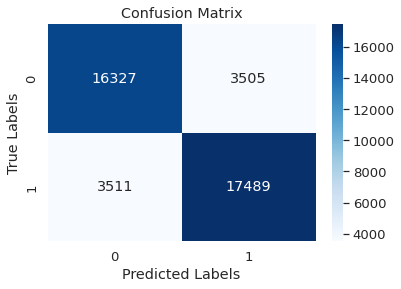

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)
model1.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in train_loader_1:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred, labels=[0,1])

# Plot confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)

with torch.no_grad():
    input_tensor = val_transforms(Image.open('/content/test_vit/F/00000100.png')).unsqueeze(0).to(device)
    outputs = model1(input_tensor)
    predicted_probs = torch.nn.functional.softmax(outputs[0], dim=0)

In [ ]:
tensor_cpu = predicted_probs.cpu()
class_labels = ['Male', 'Famele']

if (tensor_cpu.numpy()[0]>tensor_cpu.numpy()[1]):
  print(class_labels[0])
else:
  print(class_labels[1])


Famele


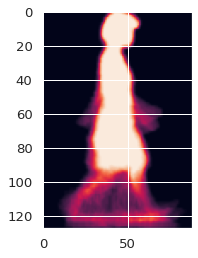

In [ ]:
plt.imshow(Image.open('/content/test_vit/F/00000111.png'))

In [ ]:
!pip install onnx

In [ ]:
!pip install onnxruntime

In [ ]:
import onnx

# create a dummy input tensor
dummy_input = torch.randn(1, 1, 224, 224)

# set the input and output names for the ONNX model
input_names = ['input']
output_names = ['output']

# move the model to the same device as the dummy input
model1.to(dummy_input.device)

# export the model to ONNX format
onnx_filename = 'vit_MF.onnx'

try:
    torch.onnx.export(model1, dummy_input, onnx_filename, input_names=input_names, output_names=output_names)
    print(f"Model successfully exported to ONNX format: {onnx_filename}")
except RuntimeError as error:
    print(f"Error occurred while exporting the model: {error}")

/usr/local/lib/python3.9/dist-packages/linformer/linformer.py:97: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert kv_len == self.seq_len, f'the sequence length of the key / values must be {self.seq_len} - {kv_len} given'


Model successfully exported to ONNX format: vit_MF.onnx


In [ ]:
import onnxruntime as ort

img = Image.open('/content/test_vit/F/00000513.png')

# apply image transforms
img = val_transforms(img)

# convert the transformed image to a NumPy array
img_np = np.array(img).astype(np.float32)
img_np = np.expand_dims(img_np, axis=0)

session = ort.InferenceSession('/content/vit_MF.onnx')
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
result = session.run([output_name], {input_name: img_np})

# print the predicted class label
class_index = np.argmax(result[0])
class_labels = ['M', 'F'] # replace with your own labels
print('Predicted class:', class_labels[class_index])


Predicted class: F


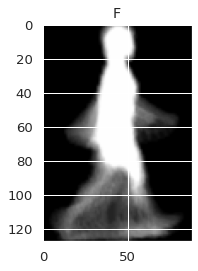

In [ ]:
image = Image.open('/content/test_vit/F/00000513.png').convert("L")
arr = np.asarray(image)
plt.title(class_labels[class_index])
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()